# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 
Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

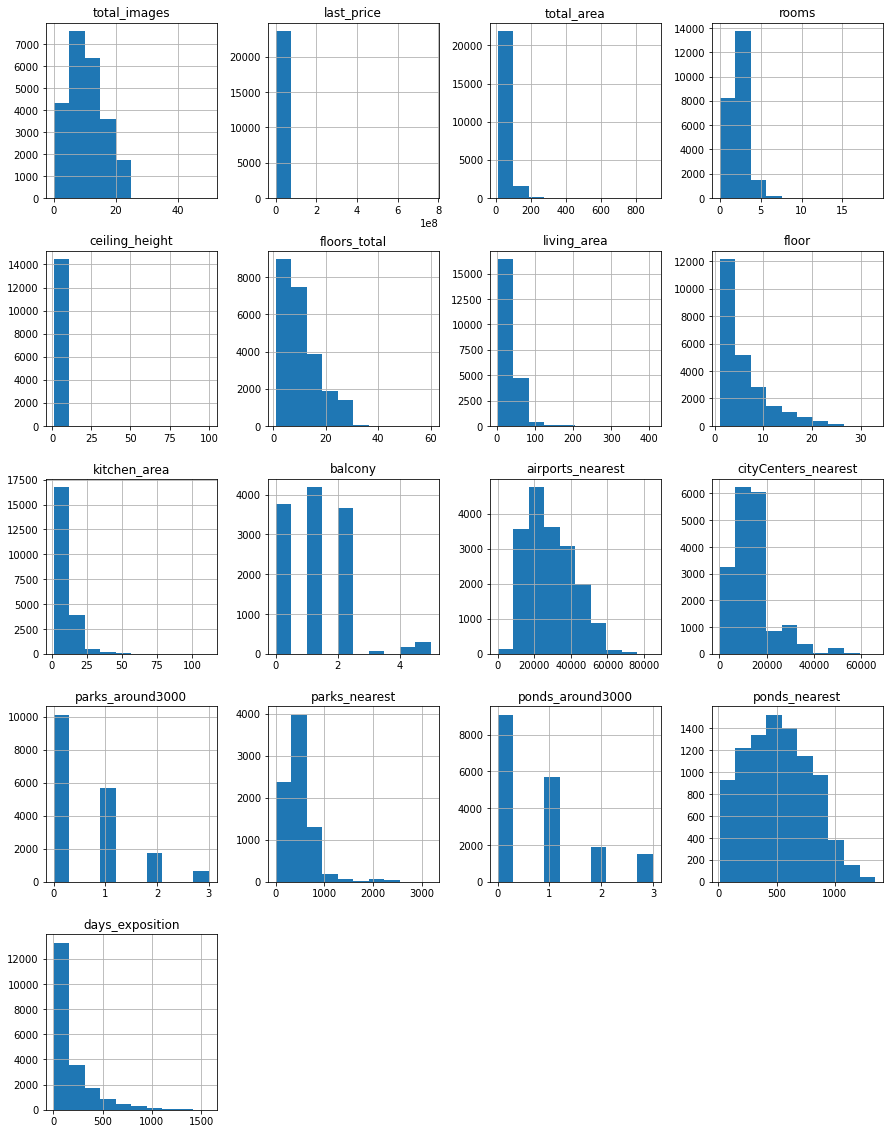

In [17]:
data.hist(figsize=(15, 20));

Была подключена библиотека Pandas, выведена информация о датафрейме, нарисованы графики столбцов датафрейма.

### Предобработка данных

In [18]:
data.isna().sum() #<= подсчет пропусков в каждом из столбцов

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски есть в столбцах, где справа от названия столбца находится число, отличное от нуля.

In [19]:
data['balcony'] = data['balcony'].fillna(0) #<= заполнили пропуски в столбце 'balcony'
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Были заполнены пропуски в столбцах 'balcony' и 'ceiling_height'. В столбце 'balcony' пропуски были заменены на '0' (продавец не указал число балконов), а в столбце 'ceiling_height' пропуски были заменены на медианные значения столбца. Пропуски в остальных столбцах не заполнялись, так как нет гарантии, что метод заполнения правильный (да и это не проект машинного обучения, где это действительно необходимо). Возможные причины возникновения пропусков в данных: технические ошибки и человеческий фактор. 

In [20]:
columns = ['last_price',
           'floors_total', 
           'balcony', 
           'airports_nearest', 
           'cityCenters_nearest',
           'parks_around3000', 
           'parks_nearest', 
           'ponds_around3000', 
           'ponds_nearest']

for col in columns:
    data[col] = data[col].astype('Int64')
    
data['days_exposition'] = data['days_exposition'].round().astype('Int64')

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,<NA>
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817,18603,0,<NA>,0,<NA>,81
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558
3,0,64900000,159.0,2015-07-24T00:00:00,3,2.65,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098,6800,2,84,3,234,424
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121


Изменениям подверглись столбцы, тип данных которых был равен float64 ('last_price', 'floors_total', 'balcony',  'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest'). Сами числа в этих столбцах не были вещественными, а значит и оставлять их float64 нет никакого смысла. Как пример, количество этажей в доме (floors_total) не может быть равным 12.5

In [21]:
len(data['locality_name'].unique())

365

Подсчет количества значений в столбце 'locality_name' до удаления неявных дубликатов.

In [22]:
str_rform = {
    'ё': 'е',
    ' при железнодорожной': '',
    'городской поселок': 'поселок городского типа'
}

names_rform = {
    'поселок Мурино': 'Мурино',
    'деревня Зимитицы': 'поселок Зимитицы',
    'деревня Щеглово': 'поселок Щеглово',
    'поселок Рабитцы': 'деревня Рабитицы',
    'садовое товарищество Приладожский': 'поселок городского типа Приладожский',
    'Кудрово': 'деревня Кудрово',
    'поселок Рябово': 'поселок городского типа Рябово',
    'коттеджный поселок Лесное': 'поселок Лесное',
}

for w, r in str_rform.items():
    data['locality_name'] = data['locality_name'].str.replace(w, r)

for w, r in names_rform.items():
    data['locality_name'] = data['locality_name'].replace(w, r)

Сначала удаляем дубликаты, которые возникли из-за двух написаний слова посе(ё)лок. Затем удаляем дубликаты типа 'поселок Рабитцы' -> 'Деревня Рабитцы'. 

In [23]:
len(data['locality_name'].unique())

315

Подсчет количества значений в столбце 'locality_name' после удаления неявных дубликатов. Уникальных элементов в столбце 'locality_name' стало меньше.

In [24]:
data = data.query('ceiling_height < 35 and ceiling_height > 1.75')
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height'] / 10)

lp1 = np.percentile(data['last_price'], 1)
lp99 = np.percentile(data['last_price'], 99)

ta1 = np.percentile(data['total_area'], 1)
ta99 = np.percentile(data['total_area'], 99)

In [12]:
data = data.query('last_price > @lp1 and last_price < @lp99')
data = data.query('total_area > @ta1 and total_area < @ta99')

In [26]:
data['rooms'].value_counts()

1     8045
2     7938
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Столбец 'ceiling_height':
Из датафрейма были удалены строки, где в столбце 'ceiling_height' (высота потолка в метрах) были значения больше 35, либо меньше 1,75. Также значения в данном столбце, которые были больше 20, были поделены на 10 (предполагаем, что, например, высота потолка равная 25 метрам должна была быть записана как 2,5 м.

Остальные столбцы ('last_price', 'total_area', 'rooms') были очищены от аномалий по принципу нахождения 1 и 99 персентиля и удаления значений, которые в эти персентили не входят.

### Добавление в таблицу новых столбцов

In [12]:
# функция, определяющая тип квартиры в объявлении ('первый', 'последний', 'другой')
def floor_typing(row):
    try:
        if row['floor'] == 1:
            return 'первый'

        elif row['floor'] == row['floors_total']:
            return 'последний'

        else:
            return 'другой'
        
    except:
        pass
    
def floor_type_numbering(row):
    try:
        return floor_type_numbers[row['floor_type']]
    
    except:
        pass
    
def day_numbering(row):
    try:
        return day_numbers[row['exposition_day']]
    
    except:
        pass

def month_numbering(row):
    try:
        return month_numbers[row['exposition_month']]
    
    except:
        pass
    
data['square_meter_price'] = data['last_price'] / data['total_area'] #<= столбец с ценой одного квадратного метра
data['to_center'] = (data['cityCenters_nearest'] / 1000).apply(np.ceil).astype('Int64') #<= расстояние до центра города в километрах

floor_type_numbers = {
    'первый': 0,
    'последний': 1,
    'другой': 2
}

day_numbers = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

first_exposition_info = pd.DatetimeIndex(data['first_day_exposition']) #<= переменная с информацией о первой дате публикации
data['exposition_day'] = first_exposition_info.day_name() #<= день
data['exposition_day_number'] = data.apply(day_numbering, axis=1) #<= номер дня

data['exposition_month'] = first_exposition_info.month_name() #<= номер месяца
data['exposition_month_number'] = first_exposition_info.month

data['exposition_year']  = first_exposition_info.year #<= год

data['floor_type'] = data.apply(floor_typing, axis=1) #<= применение функции floor_typing к датафрейму
data['floor_type_number'] = data.apply(floor_type_numbering, axis=1)

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,to_center,exposition_day,exposition_day_number,exposition_month,exposition_month_number,exposition_year,floor_type,floor_type_number
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863,16028,1,482,2,755,<NA>,120370.37037,17,Thursday,3,March,3,2019,другой,2.0
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817,18603,0,<NA>,0,<NA>,81,82920.792079,19,Tuesday,1,December,12,2018,первый,0.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785.714286,14,Thursday,3,August,8,2015,другой,2.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000.0,9,Tuesday,1,June,6,2018,другой,2.0
5,10,2890000,30.4,2018-09-10T00:00:00,1,2.65,12,14.4,5,NaN,False,False,9.1,0,поселок городского типа Янино-1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55,95065.789474,<NA>,Monday,0,September,9,2018,другой,2.0


### Исследовательский анализ данных

45.0    409
42.0    374
60.0    345
44.0    337
31.0    336
Name: total_area, dtype: int64

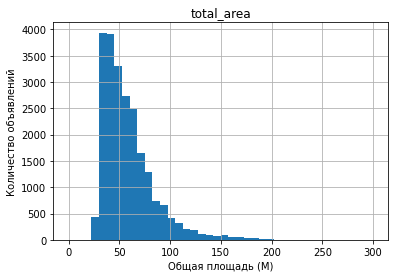

In [13]:
ta_hist = data.hist(column='total_area', bins=40, range=(0, 300))

for h in ta_hist.flatten():
    h.set_xlabel('Общая площадь (М)')
    h.set_ylabel('Количество объявлений')

data['total_area'].value_counts().head(5)

Чаще всего встречаются объявления с общей площадью помещения равной 45 метрам.

18.0    843
17.0    638
30.0    584
20.0    468
16.0    458
Name: living_area, dtype: int64

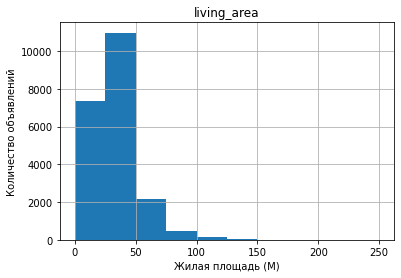

In [14]:
la_hist = data.hist(column='living_area', range=(0, 250))

for h in la_hist.flatten():
    h.set_xlabel('Жилая площадь (М)')
    h.set_ylabel('Количество объявлений')

data['living_area'].value_counts().head(5)

Чаще всего встречаются объявления с жилой площадью помещения равной 18 метрам.

10.0    1257
6.0     1239
8.0     1087
9.0     1084
7.0     1042
Name: kitchen_area, dtype: int64

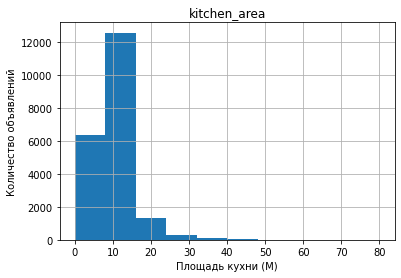

In [15]:
ka_hist = data.hist(column='kitchen_area', range=(0, 80))

for h in ka_hist.flatten():
    h.set_xlabel('Площадь кухни (М)')
    h.set_ylabel('Количество объявлений')
    
data['kitchen_area'].value_counts().head(5)

Чаще всего встречаются объявления с площадью кухни равной 6 метрам.

4500000    342
3500000    291
4300000    260
4200000    258
4000000    258
Name: last_price, dtype: Int64

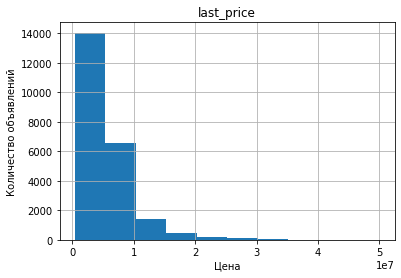

In [16]:
lp_hist = data.hist(column='last_price', range=(400_000, 50_000_000))

for h in lp_hist.flatten():
    h.set_xlabel('Цена')
    h.set_ylabel('Количество объявлений')
    
data['last_price'].value_counts().head(5)

Чаще всего встречаются объявления с ценой квартиры равной 4500000 рублей.

2    7821
1    7775
3    5705
4    1099
5     251
Name: rooms, dtype: int64

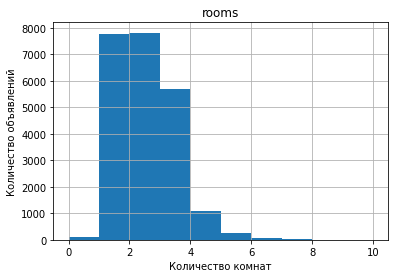

In [17]:
r_hist = data.hist(column='rooms', range=(0, 10))

for h in r_hist.flatten():
    h.set_xlabel('Количество комнат')
    h.set_ylabel('Количество объявлений')
    
data['rooms'].value_counts().head(5)

Чаще всего встречаются объявления с одной комнатой в квартире.

2.65    9440
2.50    3451
2.60    1629
2.70    1557
3.00    1057
Name: ceiling_height, dtype: int64

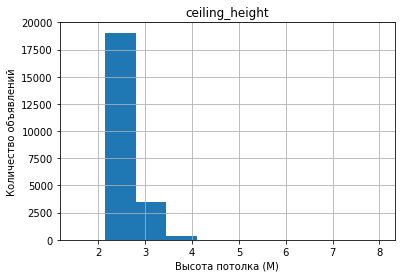

In [18]:
ch_hist = data.hist(column='ceiling_height', range=(1.5, 8))

for h in ch_hist.flatten():
    h.set_xlabel('Высота потолка (М)')
    h.set_ylabel('Количество объявлений')
    
data['ceiling_height'].value_counts().head(5)

2    3234
3    2962
1    2775
4    2689
5    2518
Name: floor, dtype: int64

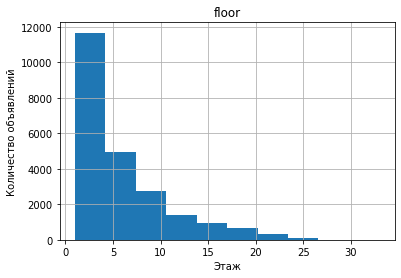

In [19]:
f_hist = data.hist(column='floor')

for h in f_hist.flatten():
    h.set_xlabel('Этаж')
    h.set_ylabel('Количество объявлений')
    
data['floor'].value_counts().head(5)

Чаще всего встречаются объявления, в которых квартира расположена на втором этаже.

5     5544
9     3714
16    1355
12    1339
10    1156
Name: floors_total, dtype: Int64

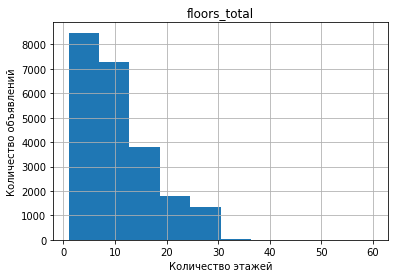

In [20]:
ft_hist = data.hist(column='floors_total')

for h in ft_hist.flatten():
    h.set_xlabel('Количество этажей')
    h.set_ylabel('Количество объявлений')
    
data['floors_total'].value_counts().head(5)

Чаще всего встречаются объявления, где квартира продается в пятиэтажке.

13    1508
15    1499
12    1397
14    1385
16    1362
Name: to_center, dtype: Int64

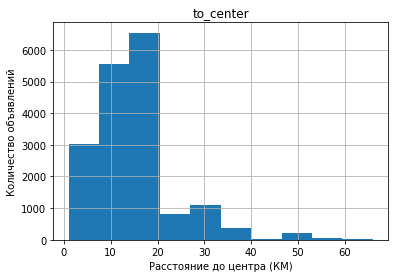

In [21]:
tc_hist = data.hist(column='to_center')

for h in tc_hist.flatten():
    h.set_xlabel('Расстояние до центра (КМ)')
    h.set_ylabel('Количество объявлений')
    
data['to_center'].value_counts().head(5)

Чаще всего встречаются объявления, где расстояние до центра города равно 13 километрам.

37434    61
21928    32
44870    30
39946    29
37407    27
Name: airports_nearest, dtype: Int64

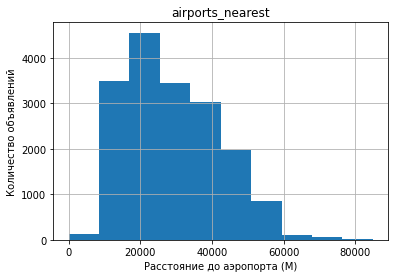

In [22]:
an_hist = data.hist(column='airports_nearest')

for h in an_hist.flatten():
    h.set_xlabel('Расстояние до аэропорта (М)')
    h.set_ylabel('Количество объявлений')
    
data['airports_nearest'].value_counts().head(5)

Чаще всего встречаются объявления, где расстояние до ближайшего аэропорта равно 20 километрам.

441    67
392    41
173    40
456    39
471    30
Name: parks_nearest, dtype: Int64

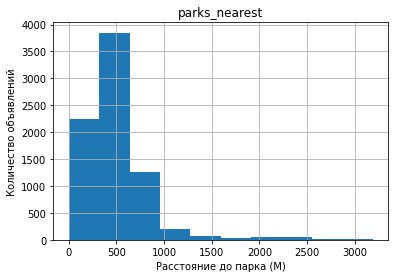

In [23]:
pn_hist = data.hist(column='parks_nearest')

for h in pn_hist.flatten():
    h.set_xlabel('Расстояние до парка (М)')
    h.set_ylabel('Количество объявлений')
    
data['parks_nearest'].value_counts().head(5)

Чаще всего встречаются объявления, где расстояние до ближайшего парка равно 500 метрам.

другой       16851
последний     3147
первый        2775
Name: floor_type, dtype: int64


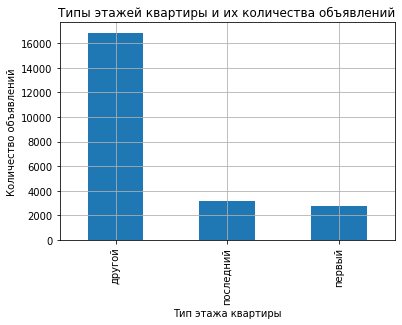

In [24]:
ft = data['floor_type'].value_counts()
print(ft)
ft.plot(kind='bar', 
        title='Типы этажей квартиры и их количества объявлений', 
        ylabel='Количество объявлений', 
        xlabel='Тип этажа квартиры', 
        grid=True);

Больше всего объявлений с типом этажа 'другой'.

Thursday     4125
Tuesday      4055
Friday       3873
Wednesday    3817
Monday       3493
Saturday     1848
Sunday       1639
Name: exposition_day, dtype: int64


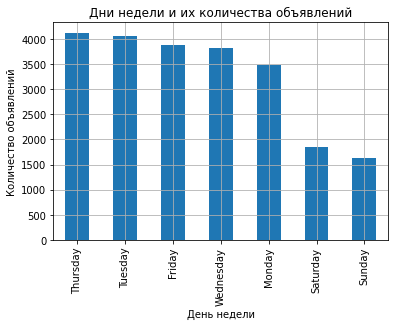

In [25]:
ed = data['exposition_day'].value_counts()
print(ed)
ed.plot(kind='bar', 
        title='Дни недели и их количества объявлений', 
        ylabel='Количество объявлений', 
        xlabel='День недели', 
        grid=True);

Больше всего объявлений было размещено в четверг.

February     2550
March        2496
April        2299
November     2287
October      2071
September    1907
June         1693
August       1682
July         1630
December     1576
January      1435
May          1224
Name: exposition_month, dtype: int64


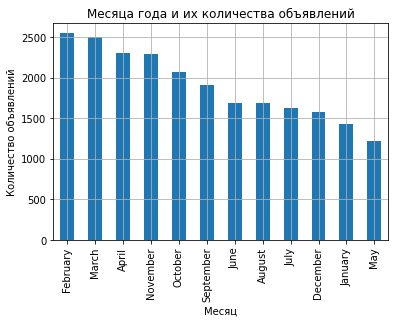

In [26]:
em = data['exposition_month'].value_counts()
print(em)
em.plot(kind='bar', 
        title='Месяца года и их количества объявлений', 
        ylabel='Количество объявлений', 
        xlabel='Месяц', 
        grid=True);

Чаще всего объявления публиковались в феврале.

Средняя длительность продажи: 180 дней.
Медианная длительность продажи: 95 дней.


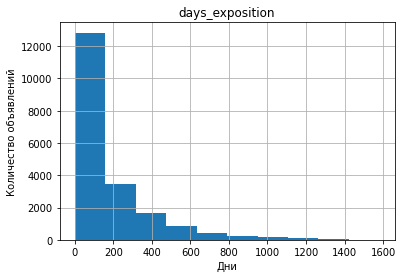

In [27]:
de_hist = data.hist(column='days_exposition')

for h in de_hist.flatten():
    h.set_xlabel('Дни')
    h.set_ylabel('Количество объявлений')
    
mn = data['days_exposition'].mean()
md = data['days_exposition'].median()
print(f'Средняя длительность продажи: {round(mn)} дней.')
print(f'Медианная длительность продажи: {round(md)} дней.')

In [28]:
data['days_exposition'].describe()

count    19821.000000
mean       180.221482
std        218.875984
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

Быстрыми можно считать продажи, которые были совершены в течение 45 дней с момента добавления объявления. Долгие продажи - те, которые были совершены в течение 230 дней с момента публикации объявления о продаже. Обычная продажа - медианное значение длительности продажи.

0.7802911839022111

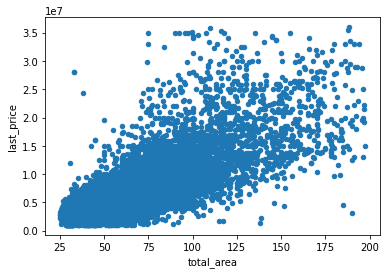

In [29]:
data.plot(x='total_area', y='last_price', kind='scatter')
data['total_area'].corr(data['last_price'].astype('float64'))

Исходя из коэффициента корреляции, равного 0.65, можно сделать вывод, что связь между общей площадью квартиры и ее ценой наблюдается.

0.6675680404476158

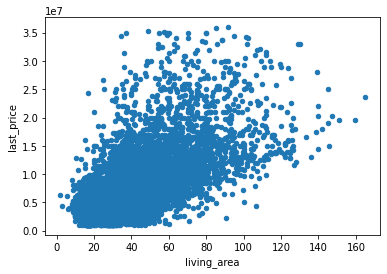

In [30]:
data.plot(x='living_area', y='last_price', kind='scatter')
data['living_area'].corr(data['last_price'].astype('float64'))

Исходя из коэффициента корреляции, равного 0.56, можно сделать вывод, что связь между жилой площадью квартиры и ее ценой наблюдается, но при этом она уже куда более слабая, нежели в случае с общей площадью.

0.5878460753611924

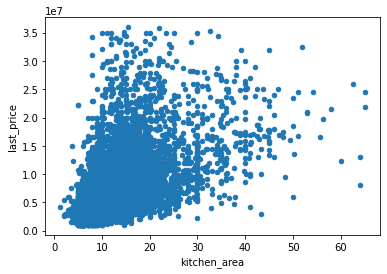

In [31]:
data.plot(x='kitchen_area', y='last_price', kind='scatter')
data['kitchen_area'].corr(data['last_price'].astype('float64'))

Исходя из коэффициента корреляции, равного 0.51, можно сделать вывод, что связь между площадью кухни и ценой квартиры наблюдается, но при этом она уже куда более слабая, нежели в случае с общей и жилой площадьми.

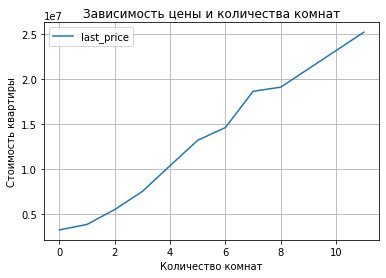

In [45]:
r_pt = pd.pivot_table(data, index=['rooms'], values=['last_price'])
r_pt.plot(title='Зависимость цены и количества комнат',
                       xlabel='Количество комнат',
                       ylabel='Стоимость квартиры',
                       grid=True);

Связь между количеством комнат и ценой квартиры есть: чем больше комнат, тем и больше цена объекта.

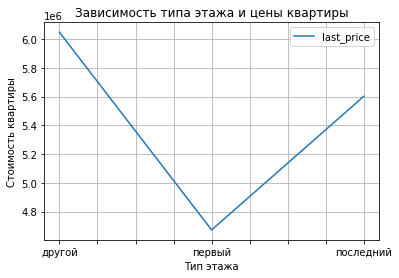

In [48]:
ft_pt = pd.pivot_table(data, index=['floor_type'], values=['last_price'])
ft_pt.plot(title='Зависимость типа этажа и цены квартиры',
                       xlabel='Тип этажа',
                       ylabel='Стоимость квартиры',
                       grid=True);

На первом этаже самые дешевые квартиры.

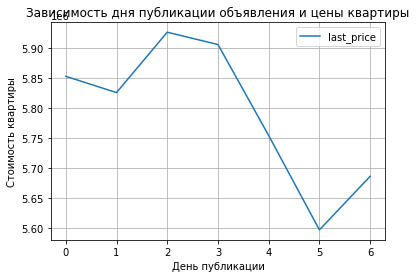

In [49]:
edn_pt = pd.pivot_table(data, index=['exposition_day_number'], values=['last_price'])
edn_pt.plot(title='Зависимость дня публикации объявления и цены квартиры',
                       xlabel='День публикации',
                       ylabel='Стоимость квартиры',
                       grid=True);

Дешевле всего квартиры, которые публиковались в субботу, дороже всего - те, которые публиковались в среду.

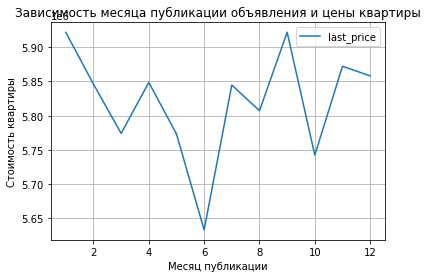

In [50]:
emn_pt = pd.pivot_table(data, index=['exposition_month_number'], values=['last_price'])
emn_pt.plot(title='Зависимость месяца публикации объявления и цены квартиры',
                       xlabel='Месяц публикации',
                       ylabel='Стоимость квартиры',
                       grid=True);

Квартиры, объявления о продаже которых были опубликованы в июне, стоили дешевле всего.

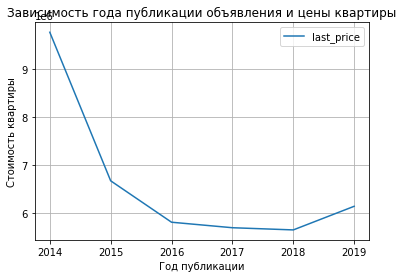

In [51]:
ey_pt = pd.pivot_table(data, index=['exposition_year'], values=['last_price'])
ey_pt.plot(title='Зависимость года публикации объявления и цены квартиры',
                       xlabel='Год публикации',
                       ylabel='Стоимость квартиры',
                       grid=True);

Квартиры дешевели с 2014 по 2018 год, с 2018 года наблюдается рост цены.

In [37]:
data['locality_name'].value_counts().head(10)

Санкт-Петербург      15255
Мурино                 551
деревня Кудрово        442
поселок Шушары         432
Всеволожск             393
Пушкин                 363
Колпино                336
поселок Парголово      325
Гатчина                306
Выборг                 228
Name: locality_name, dtype: int64

Санкт-Петербург, Мурино, деревня Кудрово, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина и Выборг - десять населенных пунктов с наибольшим количеством объявлений.

In [38]:
(data.groupby('locality_name')
 .agg({'last_price': 'count', 'square_meter_price': 'mean'})
 .sort_values(by='last_price', ascending=False)
 .reset_index().head(10)
 .style.format({'square_meter_price': '{:.0f}'})
)

,locality_name,last_price,square_meter_price
0,Санкт-Петербург,15255,110992
1,Мурино,551,85259
2,деревня Кудрово,442,94646
3,поселок Шушары,432,78152
4,Всеволожск,393,68694
5,Пушкин,363,103077
6,Колпино,336,75240
7,поселок Парголово,325,90431
8,Гатчина,306,68935
9,Выборг,228,58308


В Санкт-Петербурге самая высокая цена за квадратный метр - 114827Р, в то время как в Выборге самая низкая - 58142Р.

In [39]:
grouped_to_center = data.query('locality_name == "Санкт-Петербург"').groupby(by='to_center').mean()['square_meter_price']
grouped_to_center.head(10)

to_center
1     145748.859287
2      138632.99265
3     121570.535534
4     120029.350228
5     132431.651186
6     134564.088853
7     135076.170452
8     129504.662429
9     119705.064216
10    109646.929355
Name: square_meter_price, dtype: Float64

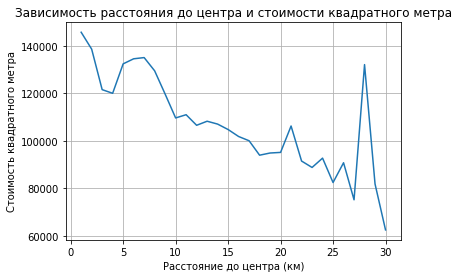

In [40]:
grouped_to_center.plot(title='Зависимость расстояния до центра и стоимости квадратного метра',
                       xlabel='Расстояние до центра (км)',
                       ylabel='Стоимость квадратного метра',
                       grid=True);

In [41]:
(data.query('locality_name == "Санкт-Петербург"')['to_center']
 .astype('float64')
 .corr(data.query('locality_name == "Санкт-Петербург"')['square_meter_price']
 .astype('float64'))
)

-0.34066697843715166

Исходя из коэффициента корреляции, равного -0.3, можно сделать вывод, что связь между ценой за квадратный метр квартиры и расстояния до центра города слабая отрицательная: чем больше расстояние до центра города, тем меньше цена за квадратный метр.

### Общий вывод

В ходе работы была воспроизведена предобработка данных: были изменены типы данных (в тех столбцах, где это было необходимо) удаленые аномальные значения и пропуски. Заменены неявные дубликаты в столбце с названиями населенных пунктов. В исходную таблицу были добавлены новые столбцы для дальнейшего анализа - цена одного квадратного метра, день недели публикации: как порядковый номер (от 0 до 6), так и обозначение на английском языке, месяц публикации объявления: как порядковый номер (от 0 до 11), так и обозначение на английском языке, год публикации объявления, тип этажа квартиры, а также расстояние до центра города в километрах. Были построены гистограммы для разных параметров объявления. Изучена длительность продажи квартиры (информация из столбца days_exposition).

Какие выводы можно сделать: стоимость квартиры зависит от расстояния до центра города, количества комнат, общей площади, площади кухни и жилой площади. Самый частый день для размещения объявления - четверг, месяц - февраль.